/home/spai0433/miniconda3/envs/py311_ad/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🔥 [Start] Detailed Visualization Pipeline

🔶 [STAGE A] 베이스 이미지 생성...
    [AI] BiRefNet 실행...


/home/spai0433/miniconda3/envs/py311_ad/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/spai0433/miniconda3/envs/py311_ad/lib/python3.11/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


    [AI] Flux 실행...


Loading pipeline components...: 100%|██████████| 7/7 [00:03<00:00,  2.07it/s]
The module 'FluxTransformer2DModel' has been loaded in `bitsandbytes` 8bit and moving it to cpu via `.to()` is not supported. Module is still on cuda:0.
  0%|          | 0/25 [00:00<?, ?it/s]/home/spai0433/miniconda3/envs/py311_ad/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:123: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
100%|██████████| 25/25 [01:02<00:00,  2.49s/it]
The module 'FluxTransformer2DModel' has been loaded in `bitsandbytes` 8bit and moving it to cpu via `.to()` is not supported. Module is still on cuda:0.



🔶 [STAGE B] 텍스트 자산 생성...
    [AI] SDXL 실행...


100%|██████████| 30/30 [00:16<00:00,  1.87it/s]


    [AI] BiRefNet 실행...

🔶 [STAGE C] 최종 합성...


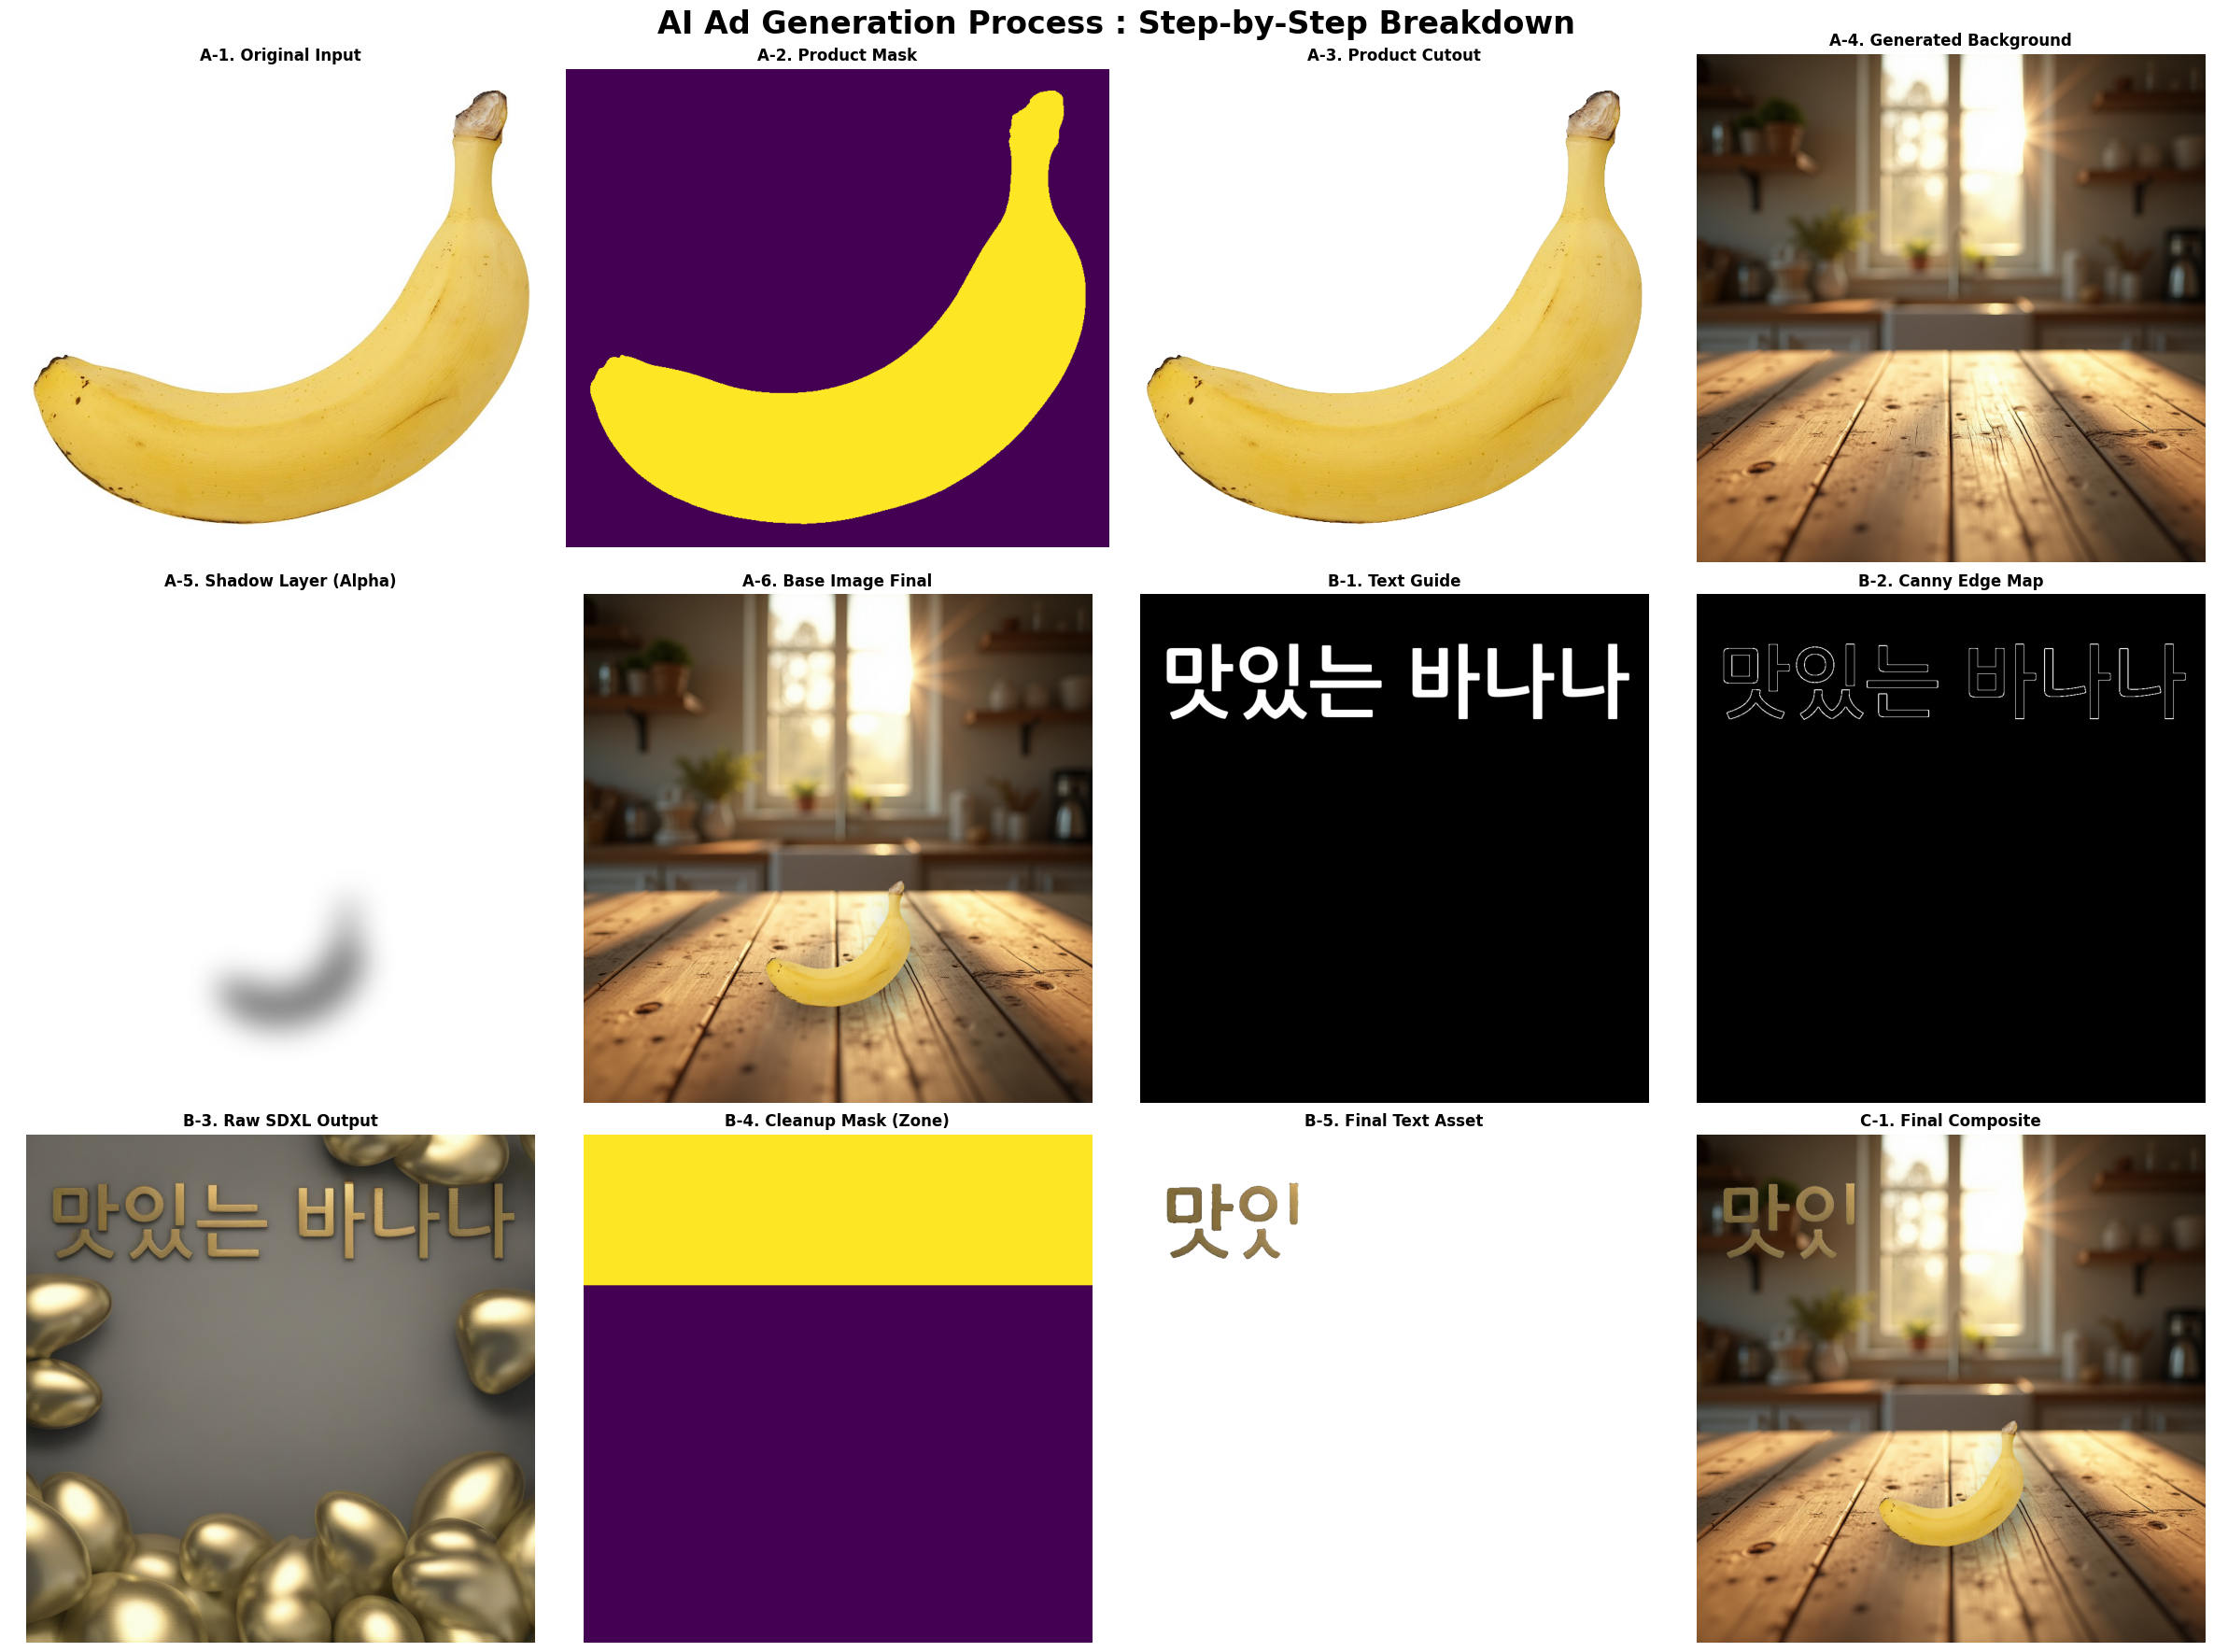


✨ 상세 리포트 생성 완료


In [1]:
import torch
import gc
import os
import requests
import numpy as np
from PIL import Image, ImageDraw, ImageFont, ImageFilter, ImageOps, ImageChops
from torchvision import transforms
from transformers import AutoModelForImageSegmentation, BitsAndBytesConfig
from diffusers import (
    FluxPipeline, 
    FluxTransformer2DModel,
    StableDiffusionXLControlNetPipeline, 
    ControlNetModel, 
    AutoencoderKL
)
from diffusers.utils import load_image
import matplotlib.pyplot as plt

# ==========================================
# ⚙️ 설정 & 유틸리티
# ==========================================
DEVICE = "cuda"
TORCH_DTYPE = torch.bfloat16 

MODEL_IDS = {
    "SEG": "ZhengPeng7/BiRefNet",
    "FLUX": "black-forest-labs/FLUX.1-dev",
    "SDXL_BASE": "stabilityai/stable-diffusion-xl-base-1.0",
    "SDXL_CNET": "diffusers/controlnet-canny-sdxl-1.0",
    "SDXL_VAE": "madebyollin/sdxl-vae-fp16-fix"
}

def flush():
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

def download_font(font_name="NanumGothicBold.ttf"):
    if not os.path.exists(font_name):
        url = "https://github.com/google/fonts/raw/main/ofl/nanumgothic/NanumGothic-Bold.ttf"
        r = requests.get(url)
        with open(font_name, 'wb') as f:
            f.write(r.content)
    return font_name

def pil_canny_edge(image):
    gray = image.convert("L")
    edges = gray.filter(ImageFilter.FIND_EDGES)
    edges = edges.point(lambda x: 255 if x > 30 else 0)
    return edges.convert("RGB")

def visualize_detailed_report(images_dict):
    """12단계 상세 리포트 시각화"""
    n = len(images_dict)
    cols = 4  # 한 줄에 4개씩 보기
    rows = (n + cols - 1) // cols
    
    plt.figure(figsize=(24, 6 * rows))
    plt.suptitle("AI Ad Generation Process : Step-by-Step Breakdown", fontsize=24, fontweight='bold', y=0.98)
    
    for i, (key, img) in enumerate(images_dict.items()):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.title(key, fontsize=12, fontweight='bold')
        plt.axis('off')
        
        # 중간 단계 이미지 저장 (디버깅용)
        safe_name = key.replace(" ", "_").replace(".", "").replace("(", "").replace(")", "")
        img.save(f"debug_{safe_name}.png")

    plt.tight_layout()
    plt.show()

# --- 내부 AI 실행 함수들 (메모리 관리 Strict) ---
def _run_birefnet_seg(image):
    print("    [AI] BiRefNet 실행...")
    flush()
    birefnet = AutoModelForImageSegmentation.from_pretrained(
        MODEL_IDS["SEG"], trust_remote_code=True
    ).to(DEVICE).eval()
    
    W, H = image.size
    img_resized = image.resize((1024, 1024), Image.LANCZOS)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    input_tensor = transform(img_resized).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        preds = birefnet(input_tensor)[-1].sigmoid().cpu()
    pred = preds[0].squeeze()
    mask = transforms.ToPILImage()(pred).resize((W, H), Image.LANCZOS)
    mask = mask.point(lambda x: 255 if x > 128 else 0)
    
    result = image.copy()
    result.putalpha(mask)
    del birefnet, input_tensor
    flush()
    return result, mask

def _run_flux_bg_gen():
    print("    [AI] Flux 실행...")
    flush()
    quant_config = BitsAndBytesConfig(load_in_8bit=True)
    transformer = FluxTransformer2DModel.from_pretrained(
        MODEL_IDS["FLUX"], subfolder="transformer", quantization_config=quant_config, torch_dtype=TORCH_DTYPE
    )
    pipe = FluxPipeline.from_pretrained(
        MODEL_IDS["FLUX"], transformer=transformer, torch_dtype=TORCH_DTYPE
    )
    pipe.enable_model_cpu_offload()
    
    prompt = (
        "A close-up view of a rustic wooden table surface. "
        "Soft morning sunlight coming from a window, creating gentle shadows. "
        "Blurred cozy kitchen background, bokeh, photorealistic, 8k, cinematic lighting."
    )
    image = pipe(
        prompt, height=1024, width=1024, num_inference_steps=25, guidance_scale=3.5,
        generator=torch.Generator("cpu").manual_seed(42)
    ).images[0]
    del pipe, transformer
    flush()
    return image

def _run_sdxl_text_gen(canny_map, prompt):
    print("    [AI] SDXL 실행...")
    flush()
    controlnet = ControlNetModel.from_pretrained(
        MODEL_IDS["SDXL_CNET"], torch_dtype=TORCH_DTYPE, use_safetensors=True
    )
    vae = AutoencoderKL.from_pretrained(MODEL_IDS["SDXL_VAE"], torch_dtype=TORCH_DTYPE)
    pipe = StableDiffusionXLControlNetPipeline.from_pretrained(
        MODEL_IDS["SDXL_BASE"], controlnet=controlnet, vae=vae, torch_dtype=TORCH_DTYPE
    ).to(DEVICE)
    
    neg_prompt = "floor, ground, dirt, debris, random shapes, multiple objects, clutter, ugly, low quality"
    generated_img = pipe(
        prompt, negative_prompt=neg_prompt, image=canny_map, 
        controlnet_conditioning_scale=1.0, num_inference_steps=30
    ).images[0]
    del pipe, controlnet, vae
    flush()
    return generated_img

# ==========================================
# 🎨 STAGE A: 베이스 이미지 (상세 시각화)
# ==========================================
def run_stage_a_detail(image_path):
    print("\n🔶 [STAGE A] 베이스 이미지 생성...")
    report = {}
    
    # 1. 원본 & 마스크
    raw_img = load_image(image_path).convert("RGB")
    report["A-1. Original Input"] = raw_img
    
    product_fg, product_mask = _run_birefnet_seg(raw_img)
    report["A-2. Product Mask"] = product_mask  # 마스크 확인용
    report["A-3. Product Cutout"] = product_fg  # 투명 배경 확인용
    
    # 2. 배경 생성
    bg_img = _run_flux_bg_gen()
    report["A-4. Generated Background"] = bg_img
    
    # 3. 그림자 & 배치
    bg_w, bg_h = bg_img.size
    scale = 0.4
    fg_resized = product_fg.resize((int(product_fg.width*scale), int(product_fg.height*scale)), Image.LANCZOS)
    fg_mask = fg_resized.split()[-1]
    
    x = (bg_w - fg_resized.width) // 2
    y = int(bg_h * 0.55)
    
    # 그림자 레이어 시각화
    shadow_layer = Image.new("RGBA", bg_img.size, (0,0,0,0))
    shadow_layer.paste((0,0,0,140), (x+20, y+40), mask=fg_mask)
    shadow_layer = shadow_layer.filter(ImageFilter.GaussianBlur(30))
    report["A-5. Shadow Layer (Alpha)"] = shadow_layer # 그림자만 따로 보기
    
    # 베이스 합성
    base_comp = bg_img.convert("RGBA")
    base_comp = Image.alpha_composite(base_comp, shadow_layer)
    fg_layer = Image.new("RGBA", bg_img.size)
    fg_layer.paste(fg_resized, (x, y))
    base_comp = Image.alpha_composite(base_comp, fg_layer)
    
    base_final = base_comp.convert("RGB")
    report["A-6. Base Image Final"] = base_final
    
    return base_final, report

# ==========================================
# 🅱️ STAGE B: 텍스트 자산 (Cleanup 과정 시각화)
# ==========================================
def run_stage_b_detail(text="맛있는 바나나"):
    print("\n🔶 [STAGE B] 텍스트 자산 생성...")
    report = {}
    W, H = 1024, 1024
    
    # 1. 가이드 & Canny
    font = ImageFont.truetype(download_font(), 160)
    text_guide = Image.new("RGB", (W, H), "black")
    draw = ImageDraw.Draw(text_guide)
    
    bbox = draw.textbbox((0,0), text, font=font)
    tw, th = bbox[2] - bbox[0], bbox[3] - bbox[1]
    # 텍스트 위치: 가로 중앙, 세로 상단(100px)
    text_x, text_y = (W - tw) // 2, 100
    
    draw.text((text_x, text_y), text, font=font, fill="white")
    canny_map = pil_canny_edge(text_guide)
    
    report["B-1. Text Guide"] = text_guide
    report["B-2. Canny Edge Map"] = canny_map
    
    # 2. SDXL Raw Output
    prompt = (
        "3D render of Gold foil balloon text, inflated, shiny metallic texture, "
        "floating in air, cinematic lighting, sharp details, isolated on black background"
    )
    raw_3d_text = _run_sdxl_text_gen(canny_map, prompt)
    report["B-3. Raw SDXL Output"] = raw_3d_text
    
    # 3. 배경 제거 (1차)
    transparent_text, _ = _run_birefnet_seg(raw_3d_text)
    
    # 4. Cleanup Mask (안전 구역 시각화)
    cleanup_mask = Image.new("L", (W, H), 0) # 기본 검은색 (삭제 영역)
    mask_draw = ImageDraw.Draw(cleanup_mask)
    margin = 50
    # 텍스트가 있는 곳까지만 흰색 (보존 영역)으로 칠함
    safe_area = (0, 0, W, text_y + th + margin)
    mask_draw.rectangle(safe_area, fill=255)
    
    report["B-4. Cleanup Mask (Zone)"] = cleanup_mask
    
    # 5. 마스크 적용 (수정된 부분)
    r, g, b, a = transparent_text.split()
    
    # [Fix] ImageOps -> ImageChops 로 변경
    # 두 이미지(알파채널, 마스크)를 비교해서 더 어두운 값을 취함
    # 즉, 마스크가 검은색(0)인 부분은 알파값도 0이 되어 투명해짐
    clean_a = ImageChops.darker(a, cleanup_mask)
    
    final_text_asset = Image.merge("RGBA", (r, g, b, clean_a))
    
    report["B-5. Final Text Asset"] = final_text_asset
    
    return final_text_asset, report

# ==========================================
# 🖼️ STAGE C: 최종 합성
# ==========================================
def run_stage_c_detail(base_image, text_asset):
    print("\n🔶 [STAGE C] 최종 합성...")
    final_comp = base_image.convert("RGBA")
    final_comp = Image.alpha_composite(final_comp, text_asset)
    final_result = final_comp.convert("RGB")
    return {"C-1. Final Composite": final_result}, final_result

# ==========================================
# 🚀 메인 실행
# ==========================================
def main_detailed_pipeline(image_path):
    print(f"🔥 [Start] Detailed Visualization Pipeline")
    full_report = {}
    
    # A
    base_img, report_a = run_stage_a_detail(image_path)
    full_report.update(report_a)
    
    # B
    text_asset, report_b = run_stage_b_detail("맛있는 바나나")
    full_report.update(report_b)
    
    # C
    report_c, final_result = run_stage_c_detail(base_img, text_asset)
    full_report.update(report_c)
    
    # 시각화 실행
    visualize_detailed_report(full_report)
    final_result.save("final_detailed_result.png")
    print("\n✨ 상세 리포트 생성 완료")

if __name__ == "__main__":
    if not os.path.exists("image.png"):
        Image.new("RGB", (512, 512), "yellow").save("image.png")
    main_detailed_pipeline("image.png")